In [61]:
# %pip install -U skorch
# %pip install seaborn
# %pip install torchviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=8a5b2524e8c9ff83899d2651c9331e37fa2d13f5ab588114297fbd0a7f93c72e
  Stored in directory: /Users/eliasschuhmacher/Library/Caches/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Imports and Constants

In [62]:
import os
import requests
from tokenizers import Tokenizer
from transformers import AutoTokenizer
from transformers import BertTokenizer
import emoji
import re
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import spacy
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datetime import datetime
import torch.optim as optim


import sklearn.metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV



import skorch
from skorch import NeuralNetClassifier
from skorch import helper

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
EMOTION1 = 'anger'
EMOTION2 = 'joy'
EMOTION3 = 'sadness'
NUM_EPOCHS = 20
BATCH_SIZE = 64

In [4]:
# use the GPU or MPS if available
if torch.cuda.is_available():       
    DEVICE = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print('Using Apple MPS')

else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")

#DEVICE = torch.device("cpu")

Using Apple MPS


# Load datasets

In [5]:
## Download and load the datasets from GitHub

# Create list with URLs to raw data
urls = ['https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt',
        'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt']
        
# Create list with names of local files inside folder 'data'
filenames = ['mapping.txt', 'test_text.txt', 'test_labels.txt', 'train_text.txt', 'train_labels.txt', 'val_text.txt', 'val_labels.txt']

# Create folder 'data' if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Download data from GitHub and save it locally
for url, filename in zip(urls, filenames):
    response = requests.get(url)
    with open(os.path.join('data', filename), 'w') as file:
        file.write(response.text)


In [6]:
## Load the data 

# Load the data into a pandas dataframe
df_train = pd.read_csv("data/train_text.txt", delimiter = '\t', header = None, names = ['text'])
df_train['labels'] = pd.read_csv("data/train_labels.txt", delimiter = '\t', header = None, names = ['labels'])
df_val = pd.read_csv("data/val_text.txt", delimiter = '\t', header = None, names = ['text'])
df_val['labels'] = pd.read_csv("data/val_labels.txt", delimiter = '\t', header = None, names = ['labels'])
df_test = pd.read_csv("data/test_text.txt", delimiter = '\t', header = None, names = ['text'])
df_test['labels'] = pd.read_csv("data/test_labels.txt", delimiter = '\t', header = None, names = ['labels'])

# Print the first 10 rows of the training set
df_train.head(10)


,text,labels
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3
5,@user but your pussy was weak from what I hear...,0
6,Making that yearly transition from excited and...,3
7,Tiller and breezy should do a collab album. Ra...,1
8,@user broadband is shocking regretting signing...,0
9,@user Look at those teef! #growl,0


In [7]:
# Load the mapping file
mapping = pd.read_csv("data/mapping.txt", delimiter = '\t', header = None, names = ['labels', 'id'])

# Create a dictionary with the mapping
mapping_dict = {}
for index, row in mapping.iterrows():
    mapping_dict[row['labels']] = row['id']

# Map the labels to the integer values
df_train['labels'] = df_train['labels'].map(mapping_dict)
df_val['labels'] = df_val['labels'].map(mapping_dict)
df_test['labels'] = df_test['labels'].map(mapping_dict)

# Print the first 10 rows of the training set
df_train.head(10)

,text,labels
0,“Worry is a down payment on a problem you may ...,optimism
1,My roommate: it's okay that we can't spell bec...,anger
2,No but that's so cute. Atsu was probably shy a...,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,anger
4,it's pretty depressing when u hit pan on ur fa...,sadness
5,@user but your pussy was weak from what I hear...,anger
6,Making that yearly transition from excited and...,sadness
7,Tiller and breezy should do a collab album. Ra...,joy
8,@user broadband is shocking regretting signing...,anger
9,@user Look at those teef! #growl,anger


## Inspect the training data

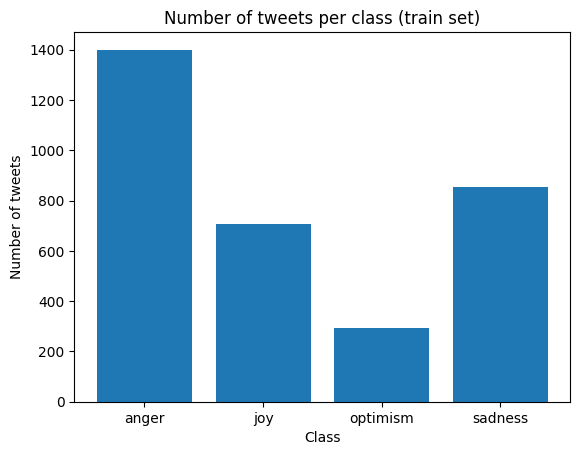

In [8]:
## Count the number of tweets per class

# Count the number of tweets per class
counts = df_train['labels'].value_counts().sort_index()

# Plot the number of tweets per class
plt.bar(counts.index, counts.values)
plt.xlabel('Class')
plt.ylabel('Number of tweets')
plt.title('Number of tweets per class (train set)')
plt.savefig('number_of_classes.png', bbox_inches='tight')
plt.show()

# Create the two datasets with chosen emotions
"Eset1": denotes the first dataset with the emotions Anger and Joy

"Eset2": denotes the second dataset with the emotions Anger and Sadness

In [9]:
# Create new train, val and test sets with only EMOTION1 and EMOTION2
df_train_Eset1 = df_train.loc[df_train['labels'].isin([EMOTION1, EMOTION2])]
df_val_Eset1 = df_val.loc[df_val['labels'].isin([EMOTION1, EMOTION2])]
df_test_Eset1 = df_test.loc[df_test['labels'].isin([EMOTION1, EMOTION2])]

# Create new train, val and test sets with only EMOTION1 and EMOTION3
df_train_Eset2 = df_train.loc[df_train['labels'].isin([EMOTION1, EMOTION3])]
df_val_Eset2 = df_val.loc[df_val['labels'].isin([EMOTION1, EMOTION3])]
df_test_Eset2 = df_test.loc[df_test['labels'].isin([EMOTION1, EMOTION3])]

## Handling class imbalance

Since the number of samples for the two classes are not equal, we need to handle the class imbalance. To handle this, we upsample the minority class. As a result, the number of samples for both classes are equal in the training set.

In [10]:
## Handle class imbalance by upsampling the minority class

# Upsample the minority class
df_train_Eset1 = df_train_Eset1.groupby('labels').apply(lambda x: x.sample(counts.max(), replace=True)).reset_index(drop=True)
df_train_Eset2 = df_train_Eset2.groupby('labels').apply(lambda x: x.sample(counts.max(), replace=True)).reset_index(drop=True)

# Print the number of tweets per class
print('Classes in first dataset:\n', df_train_Eset1['labels'].value_counts().sort_index())
print('Classes in second dataset:\n', df_train_Eset2['labels'].value_counts().sort_index())

Classes in first dataset:
 anger    1400
joy      1400
Name: labels, dtype: int64
Classes in second dataset:
 anger      1400
sadness    1400
Name: labels, dtype: int64


# Convert labels back to numerical values

Here, we convert the labels back to numerical values. This is because our models are more comfortable with numerical values :-)

Thereby, we assign the label "0" to the class "Anger" in both datasets. The label "1" is assigend to the respective other class (i.e. "Joy" in Eset1 and "Sadness" in Eset2).

In [11]:
# Map the labels to the integer values. Thereby, we assign 0 for EMOTION1 (anger) and 1 for the other emotion (EMOTION2 or EMOTION3)
df_train_Eset1['labels'] = df_train_Eset1['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})
df_val_Eset1['labels'] = df_val_Eset1['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})
df_test_Eset1['labels'] = df_test_Eset1['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})
df_train_Eset2['labels'] = df_train_Eset2['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})
df_val_Eset2['labels'] = df_val_Eset2['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})
df_test_Eset2['labels'] = df_test_Eset2['labels'].map({EMOTION1: 0, EMOTION2: 1, EMOTION3: 1})



# Data Cleaning

Here, we clean the data by applying the following steps:

1. Remove user mentions
2. Remove the hashtag symbol
3. Remove URLs

Note: We do not remove emojis here, since they might be important for the classification task.

In [12]:
# Clean the twitter text
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove the '#' symbol
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlink
    return text

Let's apply the cleaning steps to all data sets and splits.

In [13]:
# Apply the cleaning function to the text
df_train_Eset1['text'] = df_train_Eset1['text'].apply(clean_text)
df_val_Eset1['text'] = df_val_Eset1['text'].apply(clean_text)
df_test_Eset1['text'] = df_test_Eset1['text'].apply(clean_text)

df_train_Eset2['text'] = df_train_Eset2['text'].apply(clean_text)
df_val_Eset2['text'] = df_val_Eset2['text'].apply(clean_text)
df_test_Eset2['text'] = df_test_Eset2['text'].apply(clean_text)

# Tokenization

Here, we tokenize the data. We use RoBERTa, pretrained Tokenizer which is freely available on Hugging Face. The nice thing about this tokenizer is that it can also handle emojis.

In [14]:
# Load the RoBERTa tokenizer from HuggingFace (roberta tokenizer can handle emojis)
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base', use_fast=True, normalization=True)

In [15]:
# Tokenize the text, and pad and truncate it to the maximum length
def tokenize_text(df, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    for tweet in df['text']:
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            padding = 'max_length',
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(df['labels'].values)
    return input_ids, attention_masks, labels


## Padding

Since the length of the tweets is not equal, we need to pad the tweets to the same length. For this, we need to extract the maximum length of the tweets in the training set.

In [16]:
# Get the maximum length of the tweets in the training set
MAX_LEN_Eset1 = 0
for tweet in df_train_Eset1['text']:
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    MAX_LEN_Eset1 = max(MAX_LEN_Eset1, len(input_ids))

print('Max length Emotion Set 1: ', MAX_LEN_Eset1)

MAX_LEN_Eset2 = 0
for tweet in df_train_Eset2['text']:
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    MAX_LEN_Eset2 = max(MAX_LEN_Eset2, len(input_ids))

print('Max length Emotion Set 2: ', MAX_LEN_Eset2)

Max length Emotion Set 1:  62
Max length Emotion Set 2:  62


Finally, we apply the tokenizer to all data sets and splits.

In [17]:
# Tokenize the text
input_ids_train_Eset1, attention_masks_train_Eset1, labels_train_Eset1 = tokenize_text(df_train_Eset1, tokenizer, MAX_LEN_Eset1)
input_ids_val_Eset1, attention_masks_val_Eset1, labels_val_Eset1 = tokenize_text(df_val_Eset1, tokenizer, MAX_LEN_Eset1)
input_ids_test_Eset1, attention_masks_test_Eset1, labels_test_Eset1 = tokenize_text(df_test_Eset1, tokenizer, MAX_LEN_Eset1)

input_ids_train_Eset2, attention_masks_train_Eset2, labels_train_Eset2 = tokenize_text(df_train_Eset2, tokenizer, MAX_LEN_Eset2)
input_ids_val_Eset2, attention_masks_val_Eset2, labels_val_Eset2 = tokenize_text(df_val_Eset2, tokenizer, MAX_LEN_Eset2)
input_ids_test_Eset2, attention_masks_test_Eset2, labels_test_Eset2 = tokenize_text(df_test_Eset2, tokenizer, MAX_LEN_Eset2)


# Create DataSets and DataLoaders

Here, we create the datasets and dataloaders for the training, validation and test set.

In [18]:
## Create DataLoaders

# Create the DataLoader for our training set.
train_dataset_Eset1 = TensorDataset(input_ids_train_Eset1, labels_train_Eset1)
train_dataloader_Eset1 = DataLoader(train_dataset_Eset1, sampler = RandomSampler(train_dataset_Eset1), batch_size = BATCH_SIZE)

train_dataset_Eset2 = TensorDataset(input_ids_train_Eset2, labels_train_Eset2)
train_dataloader_Eset2 = DataLoader(train_dataset_Eset2, sampler = RandomSampler(train_dataset_Eset2), batch_size = BATCH_SIZE)

# Create the DataLoader for our validation set.
validation_dataset_Eset1 = TensorDataset(input_ids_val_Eset1, labels_val_Eset1)
validation_dataloader_Eset1 = DataLoader(validation_dataset_Eset1, sampler = SequentialSampler(validation_dataset_Eset1), batch_size = BATCH_SIZE)

validation_dataset_Eset2 = TensorDataset(input_ids_val_Eset2, labels_val_Eset2)
validation_dataloader_Eset2 = DataLoader(validation_dataset_Eset2, sampler = SequentialSampler(validation_dataset_Eset2), batch_size = BATCH_SIZE)

# Create the DataLoader for our test set.
test_dataset_Eset1 = TensorDataset(input_ids_test_Eset1, labels_test_Eset1)
test_dataloader_Eset1 = DataLoader(test_dataset_Eset1, sampler = SequentialSampler(test_dataset_Eset1), batch_size = BATCH_SIZE)

test_dataset_Eset2 = TensorDataset(input_ids_test_Eset2, labels_test_Eset2)
test_dataloader_Eset2 = DataLoader(test_dataset_Eset2, sampler = SequentialSampler(test_dataset_Eset2), batch_size = BATCH_SIZE)

# Create the model

Here, we create the CNN model. We use the following architecture:

1. Embedding layer
2. Convolutional layer
3. Max pooling layer
4. Dropout layer
5. Fully connected layer

In [66]:
# Create CNN model

class CNN(nn.Module):
    def __init__(self,
                 vocab_size=tokenizer.vocab_size,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN class.
        Args:
            vocab_size (int): Vocabulary size.
            embed_dim (int): Dimension of word vectors.
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN, self).__init__()
        # Random Embedding layer
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0
                                          #,max_norm=5.0
                                          )
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [67]:
cnn = CNN()
print(cnn)

CNN(
  (embedding): Embedding(50265, 300, padding_idx=0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


## Define Skorch Wrapper model

We use Skorch to wrap the PyTorch model. This allows us to use Sklearn functionalities, such as grid search. For more information, see https://skorch.readthedocs.io/en/stable/

In [20]:
## Define Skorch wrapper model

net = NeuralNetClassifier(
    #Define the model
    module = CNN,
    module__vocab_size=tokenizer.vocab_size,
    module__embed_dim=300,
    module__filter_sizes=[3, 4, 5],
    module__num_filters=[100, 100, 100],
    module__num_classes=2,
    module__dropout=0.5,

    #Define the loss function
    criterion=nn.CrossEntropyLoss,

    #Define the optimizer
    optimizer=optim.Adadelta,
    optimizer__lr=0.01,
    optimizer__rho=0.95,

    #Define the number of epochs
    max_epochs=NUM_EPOCHS,
    
    #Define the Device
    device=DEVICE,

    #Define the batch size and set random sampling for the training set
    iterator_train__shuffle=True,
    batch_size=BATCH_SIZE,

    #Define the validation set
    train_split=skorch.helper.predefined_split(validation_dataset_Eset1)
)


## Make datasets compatible with Skorch

We need to make the datasets compatible with Skorch.

Note that we first concatenate the training and validation set and then split it again. This is because we want to use the validation set for the grid search. In a next step, we can then define that the last **m** indices of the concatenated set are used for the validation set (with **m**=number of validation samples).

In [21]:
## Steps to make dataset compatible with sklearn GridSearch

# First, concat the train and validation set
train_val_dataset_Eset1 = torch.utils.data.ConcatDataset([train_dataset_Eset1, validation_dataset_Eset1])

# Now create SliceDatasets for the train and validation set
X_train_val_Eset1_sl = skorch.helper.SliceDataset(train_val_dataset_Eset1, idx=0)
y_train_val_Eset1_sl = skorch.helper.SliceDataset(train_val_dataset_Eset1, idx=1)


Here, we create the custom validation split as described above.

In [22]:
## Set correct train and validation set for the GridSearch

## Define PredefinedSplit in order to use the already defined train and validation splits
## (k-fold CV does not work since this would randomly sample from the dataset)
## see: https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets

train_size = len(train_dataset_Eset1)
dev_size = len(validation_dataset_Eset1)

# Set indices to be used for training (=first m elements of stacked train_val array with m=len(y_train))
train_indices = np.full((train_size, ), -1, dtype=int)

# The indices which have zero or positive values, will be kept in validation set
dev_indices = np.full((dev_size, ), 0, dtype=int)
fold = np.append(train_indices, dev_indices)

custom_split = sklearn.model_selection.PredefinedSplit(fold)

## Define the grid search

In [23]:
## Define the parameters to be explored in the GridSearch
params = {
    # 'lr': [0.01, 0.05],
    'module__dropout': [0.1, 0.4],
    'module__filter_sizes': [(3, 4, 5), (2, 3, 4)],
    'module__num_filters': [(50, 50, 50), (200, 100, 50), (200, 200, 200)],
}

## Define the GridSearch (note cv=custom_split which ensures that we train on the predefined train set and validate on the predefined validation set)
gs = GridSearchCV(net, params, refit=False, cv=custom_split, scoring=['accuracy', 'f1_macro'], verbose=2)

## Employ Grid Search on the first dataset (as outlined in the exercise statement)

In [24]:
## Fit the GridSearch
gs.fit(X_train_val_Eset1_sl, y_train_val_Eset1_sl)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7150       0.5136        0.7007  5.3128
      2        0.6506       0.5525        0.6976  3.4631
      3        0.6217       0.5798        0.6833  2.9915
      4        0.5903       0.5759        0.6876  2.9586
      5        0.5642       0.6070        0.6813  3.7387
      6        0.5362       0.5681        0.6898  3.8073
      7        0.5174       0.5992        0.6703  3.9046
      8        0.4877       0.6226        0.6761  4.0897
      9        0.4630       0.6109        0.6786  3.4190
     10        0.4460       0.6265        0.6698  2.8500
     11        0.4239       0.6109        0.6569  2.8147
     12        0.4075       0.6226        0.6567  2.8246
     13        0.3896       0.6187        0.6654  2.8218
     14        0.3712       0.6187        0.6589  2.8883
     15        0.3565      

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.CNN'>,
  module__dropout=0.5,
  module__embed_dim=300,
  module__filter_sizes=[3, 4, 5],
  module__num_classes=2,
  module__num_filters=[100, 100, 100],
  module__vocab_size=50265,
),
             param_grid={'module__dropout': [0.1, 0.4],
                         'module__filter_sizes': [(3, 4, 5), (2, 3, 4)],
                         'module__num_filters': [(50, 50, 50), (200, 100, 50),
                                                 (200, 200, 200)]},
             refit=False, scoring=['accuracy', 'f1_macro'], verbose=2)

## Performance report (accuracy and F1 score) of the different parameter combinations on validation set

Here, we report the performance of the different parameter combinations on the validation set on the first dataset (as outlined in the exercise statement).

In [59]:
## Print the results
keys = ['mean_test_f1_macro', 'mean_test_accuracy', 'params']
results = { key: gs.cv_results_[key] for key in keys }


## Print the results
print('-'*50)
print('Results:')
for i in range(len(results['params'])):
    print('Validation Accuracy: {:.4f} | Validation F1: {:.4f} | Params: {}'.format(results['mean_test_accuracy'][i], results['mean_test_f1_macro'][i], results['params'][i]))
print('-'*50)

--------------------------------------------------
Results:
Validation Accuracy: 0.6342 | Validation F1: 0.6153 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (3, 4, 5), 'module__num_filters': (50, 50, 50)}
Validation Accuracy: 0.6809 | Validation F1: 0.6644 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (3, 4, 5), 'module__num_filters': (200, 100, 50)}
Validation Accuracy: 0.6693 | Validation F1: 0.6411 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (3, 4, 5), 'module__num_filters': (200, 200, 200)}
Validation Accuracy: 0.6809 | Validation F1: 0.6619 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (2, 3, 4), 'module__num_filters': (50, 50, 50)}
Validation Accuracy: 0.6537 | Validation F1: 0.6292 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (2, 3, 4), 'module__num_filters': (200, 100, 50)}
Validation Accuracy: 0.6926 | Validation F1: 0.6723 | Params: {'module__dropout': 0.1, 'module__filter_sizes': (2, 3, 4), 'module__num_fil

In [69]:
# Print the results in a data frame
df = pd.DataFrame(results)
df = df.sort_values(by=['mean_test_f1_macro'], ascending=False)
df = df.reset_index(drop=True)

# Expand the params column
df = df.join(pd.DataFrame(df['params'].tolist()))

# Drop the params column
df = df.drop(columns=['params'])

# Round the results
df = df.round(3)

# Sorty by F1 score and print the results
display(df)

,mean_test_f1_macro,mean_test_accuracy,module__dropout,module__filter_sizes,module__num_filters
0,0.695,0.716,0.4,"(3, 4, 5)","(200, 200, 200)"
1,0.672,0.693,0.1,"(2, 3, 4)","(200, 200, 200)"
2,0.668,0.677,0.4,"(2, 3, 4)","(200, 200, 200)"
3,0.664,0.681,0.1,"(3, 4, 5)","(200, 100, 50)"
4,0.662,0.681,0.1,"(2, 3, 4)","(50, 50, 50)"
5,0.649,0.665,0.4,"(2, 3, 4)","(50, 50, 50)"
6,0.641,0.669,0.1,"(3, 4, 5)","(200, 200, 200)"
7,0.634,0.661,0.4,"(2, 3, 4)","(200, 100, 50)"
8,0.633,0.661,0.4,"(3, 4, 5)","(50, 50, 50)"
9,0.631,0.661,0.4,"(3, 4, 5)","(200, 100, 50)"


### Select the best-performing paramaters ...

In [26]:
## Select best parameters based on F1 score
best_params = results['params'][np.argmax(results['mean_test_f1_macro'])]

In [27]:
## Print best parameters
print('Best parameters (based on F1 macro score):\n')
for key, value in best_params.items():
    print('{}: {}'.format(key, value))

Best parameters (based on F1 macro score):

module__dropout: 0.4
module__filter_sizes: (3, 4, 5)
module__num_filters: (200, 200, 200)


### ... and retrain the model on the training set (of the first dataset)

In [28]:
cnn_eset1 = NeuralNetClassifier(
                #Define the model
                module = CNN,
                module__vocab_size=tokenizer.vocab_size,
                module__embed_dim=300,
                module__filter_sizes=[3, 4, 5],
                module__num_filters=[100, 100, 100],
                module__num_classes=2,
                module__dropout=0.5,

                #Define the loss function
                criterion=nn.CrossEntropyLoss,

                #Define the optimizer
                optimizer=optim.Adadelta,
                optimizer__lr=0.01,
                optimizer__rho=0.95,

                #Define the number of epochs
                max_epochs=NUM_EPOCHS,
                
                #Define the Device
                device=DEVICE,

                #Define the batch size and set random sampling for the training set
                iterator_train__shuffle=True,
                batch_size=BATCH_SIZE,

                #Define the validation set
                train_split=skorch.helper.predefined_split(validation_dataset_Eset1)
)


# Set best params to the model
cnn_eset1.set_params(**best_params)

# No validation needed since we are only refitting the model with the best parameters -> set train_split to None
cnn_eset1.set_params(train_split=None)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.CNN'>,
  module__dropout=0.4,
  module__embed_dim=300,
  module__filter_sizes=(3, 4, 5),
  module__num_classes=2,
  module__num_filters=(200, 200, 200),
  module__vocab_size=50265,
)

In [29]:
## Retrain the model with the best performing parameters on the training set (as outlined in the exercise statement, we shall not use the validation set for retraining)
cnn_eset1.fit(train_dataset_Eset1, y=None)


  epoch    train_loss     dur
-------  ------------  ------
      1        0.7458  4.8484
      2        0.7033  4.5597
      3        0.6628  4.8175
      4        0.6230  4.8149
      5        0.5903  4.8910
      6        0.5632  4.6343
      7        0.5305  4.5379
      8        0.5088  4.5665
      9        0.4874  4.6424
     10        0.4718  4.7073
     11        0.4428  4.7458
     12        0.4340  5.0771
     13        0.4079  4.7093
     14        0.3983  4.9003
     15        0.3802  4.7399
     16        0.3651  4.8391
     17        0.3498  4.6849
     18        0.3347  5.0433
     19        0.3202  4.6571
     20        0.3096  4.6117


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN(
    (embedding): Embedding(50265, 300, padding_idx=0)
    (conv1d_list): ModuleList(
      (0): Conv1d(300, 200, kernel_size=(3,), stride=(1,))
      (1): Conv1d(300, 200, kernel_size=(4,), stride=(1,))
      (2): Conv1d(300, 200, kernel_size=(5,), stride=(1,))
    )
    (fc): Linear(in_features=600, out_features=2, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  ),
)

## Train the model with same paramaters on the second dataset

Now, as outlined in the exercise statement, we take the best-performing parameters and train a second model with these parameters on the second dataset (Anger and Sadness).

In [30]:
# Set best params to the model
cnn_eset2 = NeuralNetClassifier(
                #Define the model
                module = CNN,
                module__vocab_size=tokenizer.vocab_size,
                module__embed_dim=300,
                module__filter_sizes=[3, 4, 5],
                module__num_filters=[100, 100, 100],
                module__num_classes=2,
                module__dropout=0.5,

                #Define the loss function
                criterion=nn.CrossEntropyLoss,

                #Define the optimizer
                optimizer=optim.Adadelta,
                optimizer__lr=0.01,
                optimizer__rho=0.95,

                #Define the number of epochs
                max_epochs=NUM_EPOCHS,
                
                #Define the Device
                device=DEVICE,

                #Define the batch size and set random sampling for the training set
                iterator_train__shuffle=True,
                batch_size=BATCH_SIZE,

                #Define the validation set
                train_split=skorch.helper.predefined_split(validation_dataset_Eset1)
)

cnn_eset2.set_params(**best_params)

# No validation needed since we are only refitting the model with the best parameters -> set train_split to None
cnn_eset2.set_params(train_split=None)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.CNN'>,
  module__dropout=0.4,
  module__embed_dim=300,
  module__filter_sizes=(3, 4, 5),
  module__num_classes=2,
  module__num_filters=(200, 200, 200),
  module__vocab_size=50265,
)

In [31]:
## Retrain the model with the best performing parameters on the training set (as outlined in the exercise statement, we shall not use the validation set for retraining)
cnn_eset2.fit(train_dataset_Eset2, y=None)


  epoch    train_loss     dur
-------  ------------  ------
      1        0.7594  5.0398
      2        0.6922  4.8970
      3        0.6749  4.9003
      4        0.6376  4.5944
      5        0.6016  4.9300
      6        0.5725  4.6427
      7        0.5471  4.8038
      8        0.5200  4.5396
      9        0.4964  4.4399
     10        0.4808  4.4982
     11        0.4657  4.7898
     12        0.4446  4.7705
     13        0.4290  4.4858
     14        0.4030  4.7621
     15        0.4000  4.5275
     16        0.3704  4.7995
     17        0.3612  4.5941
     18        0.3460  4.6744
     19        0.3334  4.5224
     20        0.3198  4.4488


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN(
    (embedding): Embedding(50265, 300, padding_idx=0)
    (conv1d_list): ModuleList(
      (0): Conv1d(300, 200, kernel_size=(3,), stride=(1,))
      (1): Conv1d(300, 200, kernel_size=(4,), stride=(1,))
      (2): Conv1d(300, 200, kernel_size=(5,), stride=(1,))
    )
    (fc): Linear(in_features=600, out_features=2, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
  ),
)

# Report performance (accuracy and F1 score) of the two models on the test set of both datasets

Lastly, we report the performance of the two models on the test set of their respective datasets.

This is, the first model on the test set of the dataset with Anger and Joy.

And, the second model on the test set of the dataset with Anger and Sadness.

In [32]:
## Get X and y of the test set
X_test_Eset1 = test_dataset_Eset1.tensors[0]
y_test_Eset1 = test_dataset_Eset1.tensors[1]

X_test_Eset2 = test_dataset_Eset2.tensors[0]
y_test_Eset2 = test_dataset_Eset2.tensors[1]

In [33]:
# Make model predictions on the test set
y_pred_Eset1 = cnn_eset1.predict_proba(X_test_Eset1)
y_pred_Eset2 = cnn_eset2.predict_proba(X_test_Eset2)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions_Eset1 = np.argmax(y_pred_Eset1, axis=1).flatten()
flat_predictions_Eset2 = np.argmax(y_pred_Eset2, axis=1).flatten()

# Convert true labels to numpy array
y_test_Eset1 = y_test_Eset1.numpy()
y_test_Eset2 = y_test_Eset2.numpy()

In [89]:
## Calculate scores

# Calculate the F1 score
f1_score_Eset1 = sklearn.metrics.f1_score(y_test_Eset1, flat_predictions_Eset1, average='macro')
f1_score_Eset2 = sklearn.metrics.f1_score(y_test_Eset2, flat_predictions_Eset2, average='macro')

# Calculate the accuracy
accuracy_Eset1 = sklearn.metrics.accuracy_score(y_test_Eset1, flat_predictions_Eset1)
accuracy_Eset2 = sklearn.metrics.accuracy_score(y_test_Eset2, flat_predictions_Eset2)

# Calculate the precision
precision_Eset1 = sklearn.metrics.precision_score(y_test_Eset1, flat_predictions_Eset1, average='macro')
precision_Eset2 = sklearn.metrics.precision_score(y_test_Eset2, flat_predictions_Eset2, average='macro')

# Calculate the recall
recall_Eset2 = sklearn.metrics.recall_score(y_test_Eset2, flat_predictions_Eset2, average='macro')
recall_Eset1 = sklearn.metrics.recall_score(y_test_Eset1, flat_predictions_Eset1, average='macro')

## print scores
print('Scores for Test Set of the first emotion combination (i.e., the one based on which params were chosen): Anger and Joy\n')
print('F1 score Anger & Joy: {:.3f}'.format(f1_score_Eset1))
print('Accuracy Anger & Joy: {:.3f}'.format(accuracy_Eset1))
print('Precision Anger & Joy: {:.3f}'.format(precision_Eset1))
print('Recall Anger & Joy: {:.3f}'.format(recall_Eset1))
print('-'*100)
print('Scores for Test Set of the second emotion combination: Anger and Sadness\n')
print('F1 score Anger & Sadness: {:.3f}'.format(f1_score_Eset2))
print('Accuracy Anger & Sadness: {:.3f}'.format(accuracy_Eset2))
print('Precision Anger & Sadness: {:.3f}'.format(precision_Eset2))
print('Recall Anger & Sadness: {:.3f}'.format(recall_Eset2))

Scores for Test Set of the first emotion combination (i.e., the one based on which params were chosen): Anger and Joy

F1 score Anger & Joy: 0.700
Accuracy Anger & Joy: 0.730
Precision Anger & Joy: 0.724
Recall Anger & Joy: 0.694
----------------------------------------------------------------------------------------------------
Scores for Test Set of the second emotion combination: Anger and Sadness

F1 score Anger & Sadness: 0.714
Accuracy Anger & Sadness: 0.737
Precision Anger & Sadness: 0.736
Recall Anger & Sadness: 0.708


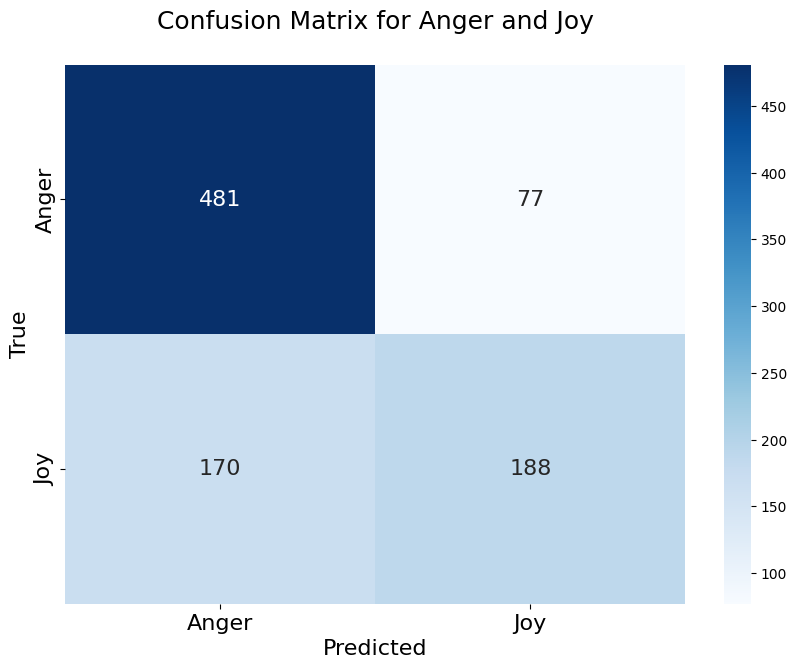

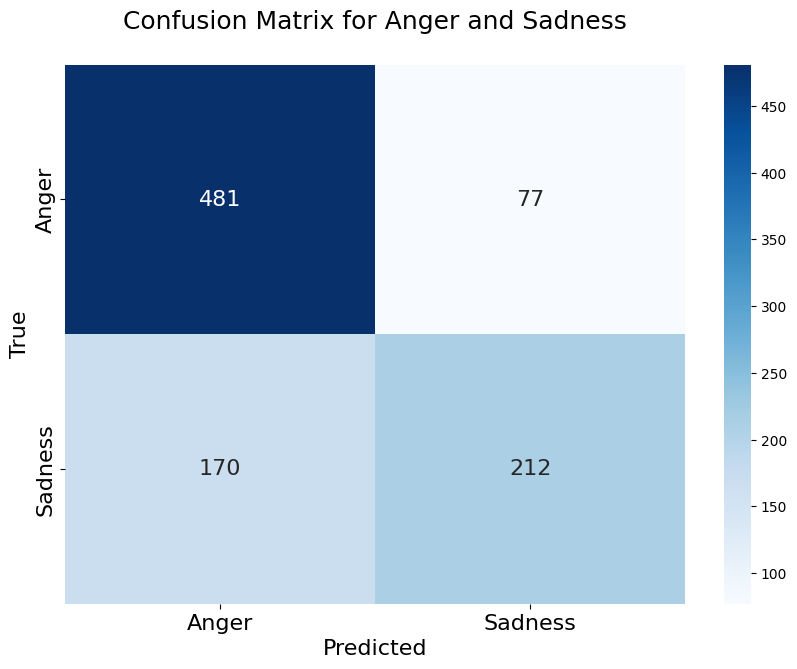

In [81]:
# Calculate confusion matrices
cm_Eset1 = sklearn.metrics.confusion_matrix(y_test_Eset1, flat_predictions_Eset1)
cm_Eset2 = sklearn.metrics.confusion_matrix(y_test_Eset2, flat_predictions_Eset2)

df_cm_eset1 = pd.DataFrame(cm_Eset1, index = [i for i in ["Anger", "Joy"]],
                    columns = [i for i in ["Anger", "Joy"]])
df_cm_eset2 = pd.DataFrame(cm_Eset2, index = [i for i in ["Anger", "Sadness"]],
                    columns = [i for i in ["Anger", "Sadness"]])

# Plot the confusion matrices in separate figures
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_eset1, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix for Anger and Joy\n', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('confusion_matrix_eset1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (10,7))
sns.heatmap(df_cm_eset2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix for Anger and Sadness\n', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('confusion_matrix_eset2.png', bbox_inches='tight')
plt.show()